# Report

---

In this notebook, we will see an implementation for an optional part of the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## Crawler

We apply the same algorithm to try to solve the Crawler problem -- with a few different hyperparameters.

#### Hyperparameters

Agent hyperparameters may be passed as constructor arguments to `MultiAgent`.  The default values, used in this workbook, are:

| parameter                | value           | description                                                                   |
|--------------------------|-----------------|-------------------------------------------------------------------------------|
| shared_network_units     | []              | Network topology for shared network between actor and critic functions        |
| actor_network_units      | [512, 512, 512] | Network topology for actor network function                                   |
| critic_network_units     | [512, 512, 512] | Network topology for critic network function                                  |
| optimizer_learning_rate  | 5e-6            | Initial learning rate for Adam optimizer                                      |
| optimizer_epsilon        | 1e-5            | Tolerance parameter for Adam optimizer                                        |
| weight_decay             | 1e-4            | Weight decay for Adam optimizer                                               |
| trajectory_length        | 1000            | Number of steps cached before trajectory rollback                             |
| gamma                    | 0.9             | Discount rate for future rewards                                              |
| gae_lambda               | 0.95            | Interpolating parameter for GAE                                               |
| optimization_steps       | 32              | Number of optimization steps to perform after trajectory rollback             |
| batch_size               | 1024            | Number of N-agent experiences to collect for a single optimization step       |
| gradient_clip            | 0.25            | Clipping parameter for gradient descent during optimization                   |
| ppo_ratio_clip_epsilon   | 0.1             | Clipping parameter for the policy loss function                               |
| entropy_penalty_weight   | 0.01            | Weight applied to entropy penalty on total loss function                      |
| value_loss_weight        | 1.0             | Weight applied to value loss on total loss function                           |
| std_init                 | -2.5            | Initialization parameter for sigma                                            |

Training hyperparameters are passed on the training function itself, `train_multiagent`, defined below.  The selected values are:

| parameter                     | value     | description                                           |
|-------------------------------|-----------|-------------------------------------------------------|
| n_episodes                    | 2000      | Maximum number of training episodes                   |
| max_t                         | 1000      | Maximum number of steps per episode                   |
| solved_score                  | 500       | Average score required to consider problem solved     |

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import deque

def train_multiagent(
    env, 
    multiagent, 
    n_episodes=300, 
    max_t=1000, 
    display_every=10,
    solved_score=30, 
    save_filename=None,
    std_scale=None
):
    scores = []
    scores_window = deque(maxlen=100)
        
    for i_episode in range(1, n_episodes + 1):    
        env_info = env.reset(train_mode=True)[brain_name]
        
        n_actors = len(env_info.vector_observations)
        score = np.zeros(n_actors)

        episode_length_list = []
        episode_counter = np.zeros(n_actors)
        
        for t in range(1, max_t+1):
            states = env_info.vector_observations
            if np.isnan(states).any():
                print('\nNaN found in states')
                break
            
            std_scale_value = 1.0 if std_scale is None else std_scale(i_episode)
            
            actions = multiagent.act(states, std_scale=std_scale_value)
            
            if np.isnan(actions).any():
                print('\nNaN found in actions')
                return scores
            
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            rewards = np.array(env_info.rewards)
            
            if np.isnan(rewards).any():
                print('\nNaN found in rewards')
                rewards = np.where(np.isnan(rewards), 0, rewards)
                
            dones = env_info.local_done
            
            multiagent.step(
                states, 
                actions, 
                rewards,
                next_states, 
                dones,
                std_scale=std_scale_value
            )
            
            score += np.array(rewards)
            score = np.where(dones, 0, score)
            
        mean_score = score.mean()
        scores_window.append(mean_score)       # save most recent score
        scores.append(mean_score)              # save most recent score
        
        print('\rEpisode {}\tAverage score: {:.2f}'.format(
            i_episode, np.mean(scores_window)
        ), end="")
        if i_episode % display_every == 0:
            print('\rEpisode {}\tAverage score: {:.2f}'.format(
                i_episode, np.mean(scores_window)
            ))
            
        if np.mean(scores_window) >= solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage score: {:.2f}'.format(
                np.maximum(i_episode-100, 0), np.mean(scores_window))
             )
            if save_filename is not None:
                multiagent.save(save_filename)
            break
    
    return scores

## Execution

Start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Crawler.app"`
- **Windows** (x86): `"path/to/Crawler_Windows_x86/Crawler.exe"`
- **Windows** (x86_64): `"path/to/Crawler_Windows_x86_64/Crawler.exe"`
- **Linux** (x86): `"path/to/Crawler_Linux/Crawler.x86"`
- **Linux** (x86_64): `"path/to/Crawler_Linux/Crawler.x86_64"`
- **Linux** (x86, headless): `"path/to/Crawler_Linux_NoVis/Crawler.x86"`
- **Linux** (x86_64, headless): `"path/to/Crawler_Linux_NoVis/Crawler.x86_64"`

For instance, if you are using a Mac, then you downloaded `Crawler.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Crawler.app")
```

In [3]:
env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [5]:
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

In [6]:
# Initialize agent

from ppo_agent import MultiAgent

Episode 100	Average score: 84.65
Episode 200	Average score: 266.36
Episode 287	Average score: 501.35
Environment solved in 187 episodes!	Average score: 501.35


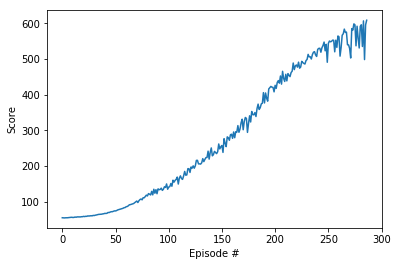

In [12]:
import torch

multiagent = MultiAgent(
    state_size=state_size, 
    action_size=action_size,
    shared_network_units=[],
    actor_network_units=[512, 512, 512],
    critic_network_units=[512, 512, 512],
    value_loss_weight=1.0,
    gradient_clip=0.25,
    ppo_ratio_clip_epsilon=0.1,
    trajectory_length=1000,
    gamma=0.9,
    gae_lambda=0.95,
    optimization_steps=32,
    batch_size=1024,
    entropy_penalty_weight=0.01,
    optimizer_learning_rate=5e-6,
    optimizer_weight_decay=1e-4,
    optimizer_epsilon=1e-5,
    std_init=-2.5
)

filename = 'checkpoint-crawler.pth'
scores = train_multiagent(
    env, 
    multiagent, 
    solved_score=500, 
    display_every=100, 
    max_t=1000,
    n_episodes=2000, 
    save_filename=filename
)
multiagent.save(filename)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
# load the weights from file
multiagent.load('checkpoint-crawler.pth')

# Run through once with loaded model
env_info = env.reset(train_mode=False)[brain_name]            # reset the environment    
states = env_info.vector_observations                         # get the current state (for each agent)
scores = np.zeros(num_agents)                                 # initialize the score (for each agent)
for t in range(1000):
    actions = multiagent.act(states, std_scale=0)             # get actions from model (for each agent)
    env_info = env.step(actions)[brain_name]                  # send all actions to tne environment
    next_states = env_info.vector_observations                # get next state (for each agent)
    rewards = env_info.rewards                                # get reward (for each agent)
    dones = env_info.local_done                               # see if episode finished
    scores += env_info.rewards                                # update the score (for each agent)
    states = next_states                                      # roll over states to next time step
    if np.any(dones):                                         # exit loop if episode finished
        break

print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 702.850885657128


When finished, we can close the environment:

In [ ]:
env.close()